In [1]:
import pandas as pd

# Load the data
# data = data = pd.read_csv("C:/Users/admin/OneDrive/maytinh/Downloads/New folder/META_stock_data.csv") 

data = pd.read_csv("C:/Users/admin/OneDrive/maytinh/Downloads/New folder/PYPL Historical Data.csv")

In [2]:
data.head()

,Date,Close,Open,High,Low,Vol.,Change %
0,6/21/2024,60.61,59.92,60.74,59.67,18.87M,1.35%
1,6/20/2024,59.80,59.25,59.99,58.79,12.87M,1.15%
2,6/18/2024,59.12,59.92,60.10,59.04,13.42M,-1.68%
3,6/17/2024,60.13,60.37,60.64,59.48,13.56M,-0.83%
4,6/14/2024,60.63,61.29,61.64,60.31,10.37M,-1.47%


In [3]:
data['MA21'] = data['Close'].rolling(window=21).mean()

In [4]:
def calculate_rsi(data, window=21):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

data['RSI'] = calculate_rsi(data['Close'])


In [5]:
data = data.dropna()  # Loại bỏ các hàng chứa giá trị NaN do tính RSI và MA

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 359 entries, 20 to 378
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      359 non-null    object 
 1   Close     359 non-null    float64
 2   Open      359 non-null    float64
 3   High      359 non-null    float64
 4   Low       359 non-null    float64
 5   Vol.      359 non-null    object 
 6   Change %  359 non-null    object 
 7   MA21      359 non-null    float64
 8   RSI       359 non-null    float64
dtypes: float64(6), object(3)
memory usage: 28.0+ KB


In [7]:
import numpy as np

# Tính toán số lượng dòng cho từng phần
total_rows = len(data)
train_size = int(0.8 * total_rows)
val_size = int(0.1 * total_rows)
test_size = total_rows - train_size - val_size 
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(how='any', axis=0, inplace=True)

# Chia DataFrame thành các tập huấn luyện, kiểm tra và kiểm định
data_train = data.iloc[:train_size]
data_val = data.iloc[train_size:train_size + val_size]
data_test = data.iloc[train_size + val_size:]

In [8]:
from sklearn.preprocessing import MinMaxScaler
import warnings

pd.options.mode.chained_assignment = None 
# Chuẩn hóa các cột giá dựa trên tập huấn luyện và áp dụng cho tập kiểm tra và kiểm định
scaler_price = MinMaxScaler(feature_range=(-1, 1))
price_columns = ['Close', 'Open', 'High', 'Low']
data_train[price_columns] = scaler_price.fit_transform(data_train[price_columns])
data_val[price_columns] = scaler_price.transform(data_val[price_columns])
data_test_copy=data_test[price_columns]
data_test[price_columns] = scaler_price.transform(data_test[price_columns])
train_data = data_train[price_columns].values
val_data = data_val[price_columns].values
test_data = data_test[price_columns].values

# Hiển thị kích thước của các tập dữ liệu
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (287, 4)
Validation data shape: (35, 4)
Test data shape: (37, 4)


In [21]:
# Training data
seq_len = 21
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i])
  y_train.append(train_data[:, 0][i])
X_train, y_train = np.array(X_train), np.array(y_train)

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 0][i])
X_val, y_val = np.array(X_val), np.array(y_val)

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (282, 21, 4) (282,)
Validation set shape (16, 21, 4) (16,)
Testing set shape (18, 21, 4) (18,)


In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Define the model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(21, 4)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 50)             │         2,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,801 (10.94 KB)

 Trainable params: 2,801 (10.94 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
import time

start_time = time.time()
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_val, y_val), verbose=1)

# Predicting and reversing normalization
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler_price.inverse_transform(np.concatenate((predicted_stock_price, np.zeros((len(predicted_stock_price), 3))), axis=1))[:,0]
end_time = time.time()
training_time = end_time - start_time

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 0.4223 - val_loss: 1.3527
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1809 - val_loss: 0.3439
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0474 - val_loss: 0.0268
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0424 - val_loss: 0.0735
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0395 - val_loss: 0.0213
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0239 - val_loss: 0.0260
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0200 - val_loss: 0.0413
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0215 - val_loss: 0.0173
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0152 - val_loss: 0.0099
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0165 - val_loss: 0.0082
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0127 - val_loss: 0.0101
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0132 - val_l

In [24]:
# Predicting and reversing normalization
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler_price.inverse_transform(np.concatenate((predicted_stock_price, np.zeros((len(predicted_stock_price), 3))), axis=1))[:,0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


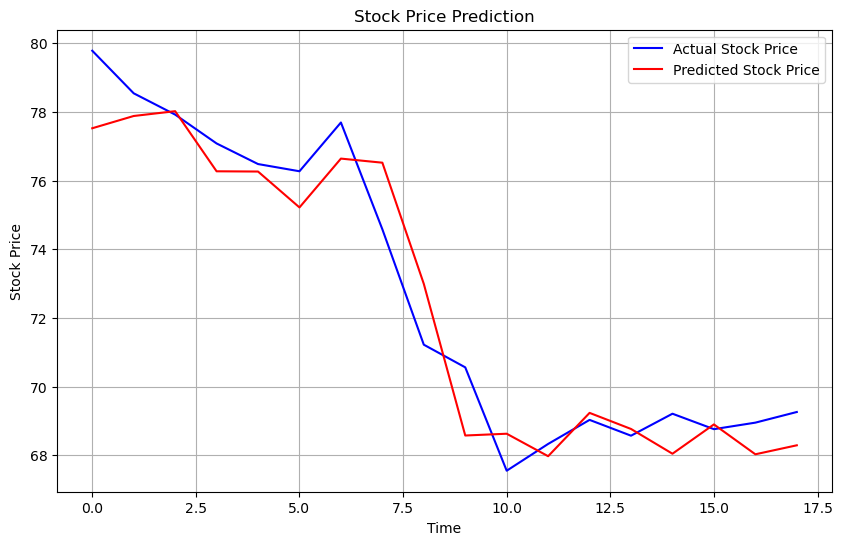

Root Mean Squared Error: 1.150706884735744
Mean Absolute Percentage Error: 0.012827978044016149
Thời gian train mô hình 19.15778923034668


In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Get actual prices from the last part of the test set
actual_prices = data_test_copy['Close'].values[seq_len:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE
rmse = mean_squared_error(actual_prices, predicted_stock_price, squared=False)
print(f"Root Mean Squared Error: {rmse}")

mape = mean_absolute_percentage_error(actual_prices, predicted_stock_price)
print(f"Mean Absolute Percentage Error: {mape}")


print('Thời gian train mô hình',training_time)